In [1]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline

## Load Dataset

In [2]:
(train_imgs,train_labels),(test_imgs,test_labels) = tf.keras.datasets.mnist.load_data(path="L:/Datasets/mnist.npz")

BufferSize = train_imgs.shape[0]
BatchSize = 128

train_imgs = train_imgs/127.5-1
train_imgs = tf.expand_dims(train_imgs,-1)
trainloader = tf.data.Dataset.from_tensor_slices((train_imgs,train_labels)).shuffle(BufferSize).batch(BatchSize)

In [3]:
train_imgs.shape

TensorShape([60000, 28, 28, 1])

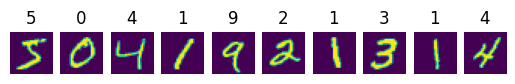

In [4]:
## View Img
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(maxNum):
        axes[i].imshow(images[i].numpy().squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

showBatchImg(train_imgs, train_labels, 10)

## infoGAN Model

```
concatenate[noise,LATENT] ==> Generator ==> Fake_Img |~~> Classifier ~~> LATENT
                                                     |==> Discriminator ==> 0/1
                                            Real_Img |


or

concatenate[noise,LATENT] ==> Generator ==> Fake_Img |
                                                     |==> Discriminator ==> 0/1 & LATENT
                                            Real_Img |



or + 已有label信息，获取新的LATENT信息（本例）

concatenate[noise,LATENT,label] ==> Generator ==> Fake_Img |
                                                           |==> Discriminator ==> 0/1 & label & LATENT
                                                  Real_Img |

```

* cGAN中的noise十分杂乱，且训练时需要输入label
* infoGAN假设noise中包含着LATENT信息，训练过程中提取LATENT信息（某种意义上可以视为自己生成label）
  - 互信息大：Given LATENT，G(noise,LATENT)生成某种图像的可能性提高；则LATENT与图像高度相关

In [5]:
noise_len = 50
latent_len = 50
label_num = 10

def Generator(): 
    seed = layers.Input(shape=(noise_len,))
    label = layers.Input(shape=(()))
    latent = layers.Input(shape=(latent_len,))
    
    Embd = layers.Embedding(label_num,noise_len)(label)
    x = layers.concatenate([seed,Embd,latent])                       ## B*150
    x = keras.Sequential(
    [
        layers.Dense(3*3*128,use_bias = False),                      ##  B*? ==> B*-
        layers.Reshape((3,3,128)),                                   ##      ==> B*3*3*128
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(64, 3, 2, use_bias=False),            ##      ==> B*7*7*64      ##  filters, kernel_size, strides
        layers.BatchNormalization(),                                                            ## = *strides + max(0,kernel_size-strides)
        layers.ReLU(),
        layers.Conv2DTranspose(32, 3, 2, padding="same", use_bias=False), ## ==> B*14*14*32     
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(1, 3, 2, padding="same", use_bias=False),  ## ==> B*28*28*1
        layers.Activation('tanh')
    ])(x)
    GModel = tf.keras.Model(inputs=[seed,label,latent],outputs=x)
    return GModel

def Discriminator():
    img = layers.Input(shape=(28,28,1))             ## B*28*28*1
    x = keras.Sequential(                     
    [
        layers.Conv2D(32, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*14*14*32
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5), 
        layers.Conv2D(64, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*7*7*64
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5),  
        layers.Conv2D(128, (3, 3),strides=(2, 2), padding="same", use_bias=False),  
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5),  
        layers.Flatten(),                                                            ##  ==> B*3136
        
    ])(img)
    out1 = layers.Dense(1)(x)                                                        ## 0/1   logits: 未被 Activation 处理
    out2 = layers.Dense(label_num)(x)                                                ## label class
    out3 = layers.Dense(latent_len)(x)                                               ## latent info
    DModel = tf.keras.Model(inputs=img,outputs=[out1,out2,out3])
    return DModel


Epoch 1----Generator Loss:: 6.931013----Discriminator Loss:: 10.749868
Epoch 1----Generator Loss:: 7.597010----Discriminator Loss:: 8.520493
Epoch 1----Generator Loss:: 6.842372----Discriminator Loss:: 7.293704
Epoch 1----Generator Loss:: 6.230922----Discriminator Loss:: 6.913520
Epoch 1----Generator Loss:: 5.757615----Discriminator Loss:: 6.677233


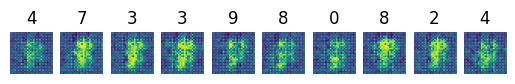

Epoch 2----Generator Loss:: 5.314274----Discriminator Loss:: 6.084260
Epoch 2----Generator Loss:: 4.563154----Discriminator Loss:: 5.347963
Epoch 2----Generator Loss:: 3.236950----Discriminator Loss:: 4.629647
Epoch 2----Generator Loss:: 3.008621----Discriminator Loss:: 3.705009
Epoch 2----Generator Loss:: 2.699158----Discriminator Loss:: 3.204953


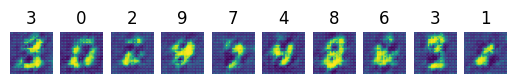

Epoch 3----Generator Loss:: 2.529032----Discriminator Loss:: 3.529051
Epoch 3----Generator Loss:: 2.338128----Discriminator Loss:: 3.028780
Epoch 3----Generator Loss:: 2.627561----Discriminator Loss:: 2.976811
Epoch 3----Generator Loss:: 2.361639----Discriminator Loss:: 3.027050
Epoch 3----Generator Loss:: 2.362221----Discriminator Loss:: 2.556896


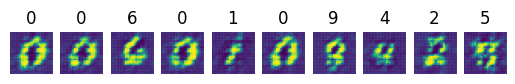

Epoch 4----Generator Loss:: 2.424542----Discriminator Loss:: 2.618542
Epoch 4----Generator Loss:: 2.293744----Discriminator Loss:: 2.886255
Epoch 4----Generator Loss:: 2.164813----Discriminator Loss:: 2.910304
Epoch 4----Generator Loss:: 2.111716----Discriminator Loss:: 3.039031
Epoch 4----Generator Loss:: 2.244930----Discriminator Loss:: 2.819688


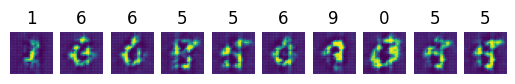

Epoch 5----Generator Loss:: 2.094740----Discriminator Loss:: 2.865144
Epoch 5----Generator Loss:: 2.270562----Discriminator Loss:: 2.732816
Epoch 5----Generator Loss:: 1.851581----Discriminator Loss:: 2.734489
Epoch 5----Generator Loss:: 2.104392----Discriminator Loss:: 2.562635
Epoch 5----Generator Loss:: 2.007561----Discriminator Loss:: 2.894383


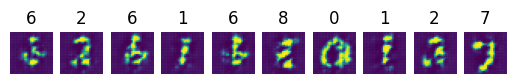

Epoch 6----Generator Loss:: 2.182266----Discriminator Loss:: 2.853792
Epoch 6----Generator Loss:: 1.913648----Discriminator Loss:: 2.756298
Epoch 6----Generator Loss:: 2.034026----Discriminator Loss:: 2.573981
Epoch 6----Generator Loss:: 1.904229----Discriminator Loss:: 2.666271
Epoch 6----Generator Loss:: 1.936453----Discriminator Loss:: 2.628922


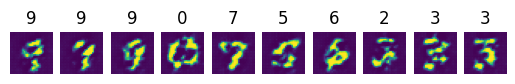

Epoch 7----Generator Loss:: 1.876322----Discriminator Loss:: 2.426536
Epoch 7----Generator Loss:: 1.909546----Discriminator Loss:: 2.497315
Epoch 7----Generator Loss:: 2.011442----Discriminator Loss:: 2.431051
Epoch 7----Generator Loss:: 1.964224----Discriminator Loss:: 2.433960
Epoch 7----Generator Loss:: 1.898532----Discriminator Loss:: 2.341362


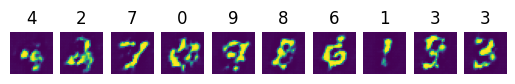

Epoch 8----Generator Loss:: 1.861139----Discriminator Loss:: 2.798300
Epoch 8----Generator Loss:: 1.763067----Discriminator Loss:: 2.459585
Epoch 8----Generator Loss:: 1.776452----Discriminator Loss:: 2.738061
Epoch 8----Generator Loss:: 1.899028----Discriminator Loss:: 2.543464
Epoch 8----Generator Loss:: 1.732377----Discriminator Loss:: 2.306293


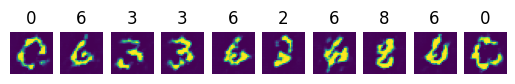

Epoch 9----Generator Loss:: 1.745346----Discriminator Loss:: 2.478943
Epoch 9----Generator Loss:: 1.793954----Discriminator Loss:: 2.377070
Epoch 9----Generator Loss:: 1.740719----Discriminator Loss:: 2.502202
Epoch 9----Generator Loss:: 1.665081----Discriminator Loss:: 2.392529
Epoch 9----Generator Loss:: 1.726462----Discriminator Loss:: 2.404875


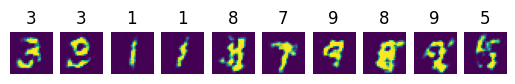

Epoch 10----Generator Loss:: 1.648848----Discriminator Loss:: 2.491643
Epoch 10----Generator Loss:: 1.734810----Discriminator Loss:: 2.337592
Epoch 10----Generator Loss:: 1.674185----Discriminator Loss:: 2.349268
Epoch 10----Generator Loss:: 1.694469----Discriminator Loss:: 2.303395
Epoch 10----Generator Loss:: 1.764991----Discriminator Loss:: 2.218566


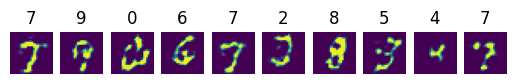

Epoch 11----Generator Loss:: 1.540790----Discriminator Loss:: 2.491486
Epoch 11----Generator Loss:: 1.562468----Discriminator Loss:: 2.361485
Epoch 11----Generator Loss:: 1.595831----Discriminator Loss:: 2.459110
Epoch 11----Generator Loss:: 1.665748----Discriminator Loss:: 2.274776
Epoch 11----Generator Loss:: 1.776535----Discriminator Loss:: 2.204184


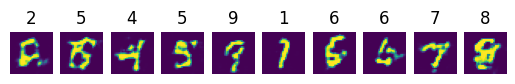

Epoch 12----Generator Loss:: 1.689713----Discriminator Loss:: 2.484311
Epoch 12----Generator Loss:: 1.639059----Discriminator Loss:: 2.262778
Epoch 12----Generator Loss:: 1.679029----Discriminator Loss:: 2.406817
Epoch 12----Generator Loss:: 1.692052----Discriminator Loss:: 2.468903
Epoch 12----Generator Loss:: 1.691149----Discriminator Loss:: 2.437407


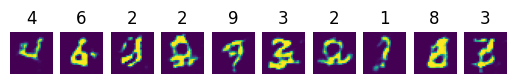

Epoch 13----Generator Loss:: 1.654572----Discriminator Loss:: 2.279813
Epoch 13----Generator Loss:: 1.599030----Discriminator Loss:: 2.361305
Epoch 13----Generator Loss:: 1.680367----Discriminator Loss:: 2.334911
Epoch 13----Generator Loss:: 1.659710----Discriminator Loss:: 2.286458
Epoch 13----Generator Loss:: 1.547623----Discriminator Loss:: 2.333885


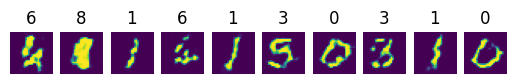

Epoch 14----Generator Loss:: 1.715112----Discriminator Loss:: 2.469560
Epoch 14----Generator Loss:: 1.625603----Discriminator Loss:: 2.263206
Epoch 14----Generator Loss:: 1.574171----Discriminator Loss:: 2.162981
Epoch 14----Generator Loss:: 1.565527----Discriminator Loss:: 2.363143
Epoch 14----Generator Loss:: 1.629225----Discriminator Loss:: 2.238588


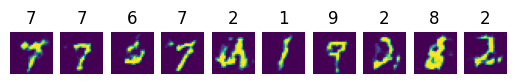

Epoch 15----Generator Loss:: 1.640609----Discriminator Loss:: 2.201458
Epoch 15----Generator Loss:: 1.600538----Discriminator Loss:: 2.266439
Epoch 15----Generator Loss:: 1.677356----Discriminator Loss:: 2.264356
Epoch 15----Generator Loss:: 1.669912----Discriminator Loss:: 2.221801
Epoch 15----Generator Loss:: 1.654632----Discriminator Loss:: 2.302946


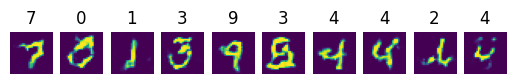

Epoch 16----Generator Loss:: 1.522603----Discriminator Loss:: 2.305415
Epoch 16----Generator Loss:: 1.628267----Discriminator Loss:: 2.127317
Epoch 16----Generator Loss:: 1.642447----Discriminator Loss:: 2.357839
Epoch 16----Generator Loss:: 1.587952----Discriminator Loss:: 2.093842
Epoch 16----Generator Loss:: 1.632121----Discriminator Loss:: 2.189665


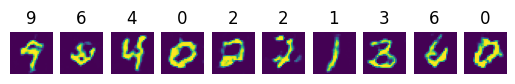

Epoch 17----Generator Loss:: 1.665747----Discriminator Loss:: 2.124490
Epoch 17----Generator Loss:: 1.567351----Discriminator Loss:: 2.200399
Epoch 17----Generator Loss:: 1.693267----Discriminator Loss:: 2.292356
Epoch 17----Generator Loss:: 1.658566----Discriminator Loss:: 2.258721
Epoch 17----Generator Loss:: 1.670077----Discriminator Loss:: 2.348484


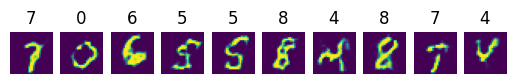

Epoch 18----Generator Loss:: 1.510189----Discriminator Loss:: 2.275669
Epoch 18----Generator Loss:: 1.707115----Discriminator Loss:: 2.189099
Epoch 18----Generator Loss:: 1.609885----Discriminator Loss:: 2.309071
Epoch 18----Generator Loss:: 1.589021----Discriminator Loss:: 2.330582
Epoch 18----Generator Loss:: 1.586869----Discriminator Loss:: 2.321606


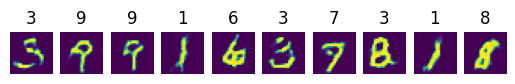

Epoch 19----Generator Loss:: 1.501202----Discriminator Loss:: 2.296303
Epoch 19----Generator Loss:: 1.532379----Discriminator Loss:: 2.329345
Epoch 19----Generator Loss:: 1.651051----Discriminator Loss:: 2.090646
Epoch 19----Generator Loss:: 1.654462----Discriminator Loss:: 2.364557
Epoch 19----Generator Loss:: 1.648399----Discriminator Loss:: 2.219620


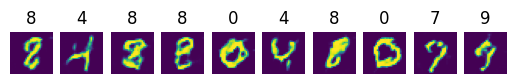

Epoch 20----Generator Loss:: 1.515648----Discriminator Loss:: 2.458009
Epoch 20----Generator Loss:: 1.585427----Discriminator Loss:: 2.317701
Epoch 20----Generator Loss:: 1.515244----Discriminator Loss:: 2.262595
Epoch 20----Generator Loss:: 1.518842----Discriminator Loss:: 2.097192
Epoch 20----Generator Loss:: 1.579505----Discriminator Loss:: 2.320404


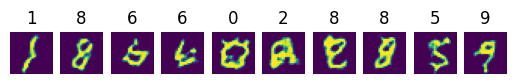

Epoch 21----Generator Loss:: 1.674325----Discriminator Loss:: 2.208906
Epoch 21----Generator Loss:: 1.631462----Discriminator Loss:: 2.071136
Epoch 21----Generator Loss:: 1.536327----Discriminator Loss:: 2.157325
Epoch 21----Generator Loss:: 1.588251----Discriminator Loss:: 2.096818
Epoch 21----Generator Loss:: 1.557046----Discriminator Loss:: 2.199359


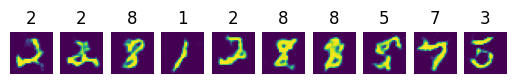

Epoch 22----Generator Loss:: 1.523250----Discriminator Loss:: 2.154484
Epoch 22----Generator Loss:: 1.509561----Discriminator Loss:: 2.347479
Epoch 22----Generator Loss:: 1.581969----Discriminator Loss:: 2.239922
Epoch 22----Generator Loss:: 1.616439----Discriminator Loss:: 2.209947
Epoch 22----Generator Loss:: 1.580742----Discriminator Loss:: 2.395420


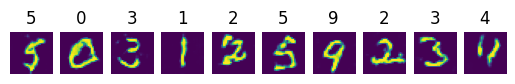

Epoch 23----Generator Loss:: 1.548248----Discriminator Loss:: 2.244758
Epoch 23----Generator Loss:: 1.483433----Discriminator Loss:: 2.341677
Epoch 23----Generator Loss:: 1.591715----Discriminator Loss:: 2.122013
Epoch 23----Generator Loss:: 1.576964----Discriminator Loss:: 2.285633
Epoch 23----Generator Loss:: 1.595354----Discriminator Loss:: 2.324467


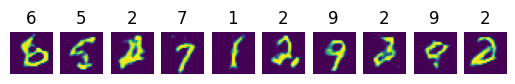

Epoch 24----Generator Loss:: 1.613461----Discriminator Loss:: 2.307625
Epoch 24----Generator Loss:: 1.484187----Discriminator Loss:: 2.318458
Epoch 24----Generator Loss:: 1.561253----Discriminator Loss:: 2.267249
Epoch 24----Generator Loss:: 1.506179----Discriminator Loss:: 2.266882
Epoch 24----Generator Loss:: 1.602159----Discriminator Loss:: 2.218163


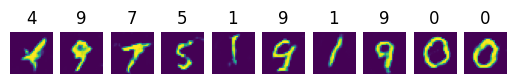

Epoch 25----Generator Loss:: 1.576089----Discriminator Loss:: 2.271383
Epoch 25----Generator Loss:: 1.507233----Discriminator Loss:: 2.231169
Epoch 25----Generator Loss:: 1.529560----Discriminator Loss:: 2.240509
Epoch 25----Generator Loss:: 1.596985----Discriminator Loss:: 2.182370
Epoch 25----Generator Loss:: 1.600964----Discriminator Loss:: 2.251853


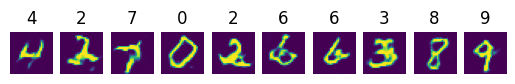

Epoch 26----Generator Loss:: 1.577408----Discriminator Loss:: 2.217105
Epoch 26----Generator Loss:: 1.507755----Discriminator Loss:: 2.478515
Epoch 26----Generator Loss:: 1.574176----Discriminator Loss:: 2.309931
Epoch 26----Generator Loss:: 1.625738----Discriminator Loss:: 2.218865
Epoch 26----Generator Loss:: 1.630237----Discriminator Loss:: 2.298799


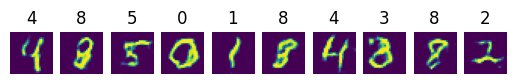

Epoch 27----Generator Loss:: 1.575093----Discriminator Loss:: 2.192744
Epoch 27----Generator Loss:: 1.469917----Discriminator Loss:: 2.287234
Epoch 27----Generator Loss:: 1.640582----Discriminator Loss:: 2.360029
Epoch 27----Generator Loss:: 1.676841----Discriminator Loss:: 2.135820
Epoch 27----Generator Loss:: 1.641585----Discriminator Loss:: 2.147369


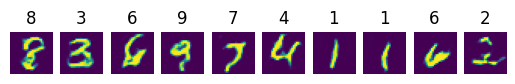

Epoch 28----Generator Loss:: 1.611015----Discriminator Loss:: 2.263396
Epoch 28----Generator Loss:: 1.418066----Discriminator Loss:: 2.431323
Epoch 28----Generator Loss:: 1.538541----Discriminator Loss:: 2.258559
Epoch 28----Generator Loss:: 1.495689----Discriminator Loss:: 2.221931
Epoch 28----Generator Loss:: 1.476744----Discriminator Loss:: 2.327617


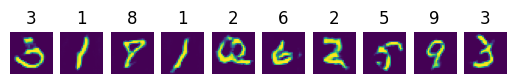

Epoch 29----Generator Loss:: 1.489424----Discriminator Loss:: 2.427323
Epoch 29----Generator Loss:: 1.526044----Discriminator Loss:: 2.281090
Epoch 29----Generator Loss:: 1.517513----Discriminator Loss:: 2.274641
Epoch 29----Generator Loss:: 1.532330----Discriminator Loss:: 2.224021
Epoch 29----Generator Loss:: 1.504748----Discriminator Loss:: 2.381117


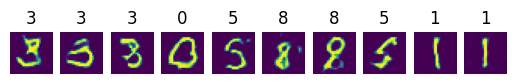

Epoch 30----Generator Loss:: 1.580218----Discriminator Loss:: 2.415726
Epoch 30----Generator Loss:: 1.522962----Discriminator Loss:: 2.309871
Epoch 30----Generator Loss:: 1.517988----Discriminator Loss:: 2.353564
Epoch 30----Generator Loss:: 1.641914----Discriminator Loss:: 2.138974
Epoch 30----Generator Loss:: 1.494823----Discriminator Loss:: 2.148315


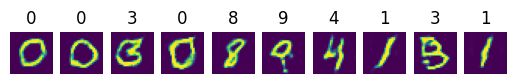

Epoch 31----Generator Loss:: 1.507580----Discriminator Loss:: 2.273345
Epoch 31----Generator Loss:: 1.615998----Discriminator Loss:: 2.038296
Epoch 31----Generator Loss:: 1.527611----Discriminator Loss:: 2.334766
Epoch 31----Generator Loss:: 1.513357----Discriminator Loss:: 2.176274
Epoch 31----Generator Loss:: 1.544158----Discriminator Loss:: 2.354633


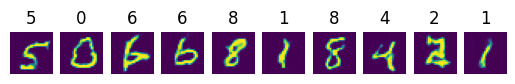

Epoch 32----Generator Loss:: 1.561508----Discriminator Loss:: 2.258099
Epoch 32----Generator Loss:: 1.509520----Discriminator Loss:: 2.208178
Epoch 32----Generator Loss:: 1.663083----Discriminator Loss:: 2.213347
Epoch 32----Generator Loss:: 1.627715----Discriminator Loss:: 2.291614
Epoch 32----Generator Loss:: 1.526779----Discriminator Loss:: 2.075234


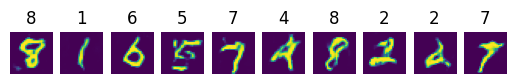

Epoch 33----Generator Loss:: 1.598179----Discriminator Loss:: 2.246800
Epoch 33----Generator Loss:: 1.528990----Discriminator Loss:: 2.410484
Epoch 33----Generator Loss:: 1.595764----Discriminator Loss:: 2.160858
Epoch 33----Generator Loss:: 1.484616----Discriminator Loss:: 2.370668
Epoch 33----Generator Loss:: 1.572651----Discriminator Loss:: 2.265522


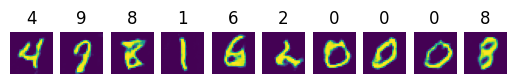

Epoch 34----Generator Loss:: 1.554254----Discriminator Loss:: 2.223150
Epoch 34----Generator Loss:: 1.556091----Discriminator Loss:: 2.289425
Epoch 34----Generator Loss:: 1.600550----Discriminator Loss:: 2.153825
Epoch 34----Generator Loss:: 1.666957----Discriminator Loss:: 2.276177
Epoch 34----Generator Loss:: 1.587038----Discriminator Loss:: 2.241368


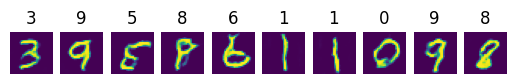

Epoch 35----Generator Loss:: 1.596494----Discriminator Loss:: 2.187323
Epoch 35----Generator Loss:: 1.621583----Discriminator Loss:: 2.369736
Epoch 35----Generator Loss:: 1.549381----Discriminator Loss:: 2.271532
Epoch 35----Generator Loss:: 1.506625----Discriminator Loss:: 2.210610
Epoch 35----Generator Loss:: 1.540714----Discriminator Loss:: 2.249311


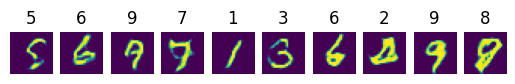

Epoch 36----Generator Loss:: 1.723513----Discriminator Loss:: 2.075519
Epoch 36----Generator Loss:: 1.630092----Discriminator Loss:: 2.249071
Epoch 36----Generator Loss:: 1.652040----Discriminator Loss:: 2.270309
Epoch 36----Generator Loss:: 1.492432----Discriminator Loss:: 2.129881
Epoch 36----Generator Loss:: 1.604214----Discriminator Loss:: 2.188038


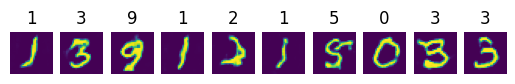

Epoch 37----Generator Loss:: 1.601842----Discriminator Loss:: 2.164096
Epoch 37----Generator Loss:: 1.665337----Discriminator Loss:: 2.196118
Epoch 37----Generator Loss:: 1.454692----Discriminator Loss:: 2.267079
Epoch 37----Generator Loss:: 1.646164----Discriminator Loss:: 2.187607
Epoch 37----Generator Loss:: 1.609079----Discriminator Loss:: 2.260835


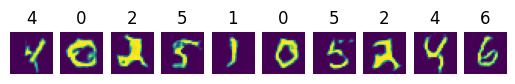

Epoch 38----Generator Loss:: 1.534435----Discriminator Loss:: 2.189197
Epoch 38----Generator Loss:: 1.435170----Discriminator Loss:: 2.281711
Epoch 38----Generator Loss:: 1.657040----Discriminator Loss:: 2.153300
Epoch 38----Generator Loss:: 1.545654----Discriminator Loss:: 2.274268
Epoch 38----Generator Loss:: 1.516359----Discriminator Loss:: 2.358526


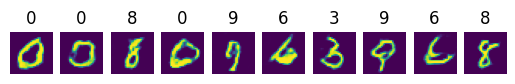

Epoch 39----Generator Loss:: 1.466139----Discriminator Loss:: 2.361641
Epoch 39----Generator Loss:: 1.471158----Discriminator Loss:: 2.382787
Epoch 39----Generator Loss:: 1.472410----Discriminator Loss:: 2.317793
Epoch 39----Generator Loss:: 1.617706----Discriminator Loss:: 2.268837
Epoch 39----Generator Loss:: 1.529361----Discriminator Loss:: 2.176536


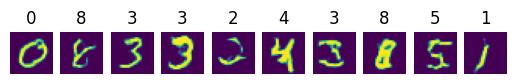

Epoch 40----Generator Loss:: 1.531490----Discriminator Loss:: 2.403369
Epoch 40----Generator Loss:: 1.512077----Discriminator Loss:: 2.160427
Epoch 40----Generator Loss:: 1.574383----Discriminator Loss:: 2.310122
Epoch 40----Generator Loss:: 1.476332----Discriminator Loss:: 2.240043
Epoch 40----Generator Loss:: 1.568275----Discriminator Loss:: 2.331801


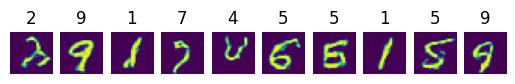

Epoch 41----Generator Loss:: 1.474805----Discriminator Loss:: 2.215875
Epoch 41----Generator Loss:: 1.676508----Discriminator Loss:: 2.214320
Epoch 41----Generator Loss:: 1.658495----Discriminator Loss:: 2.056636
Epoch 41----Generator Loss:: 1.610054----Discriminator Loss:: 2.135850
Epoch 41----Generator Loss:: 1.610532----Discriminator Loss:: 2.192984


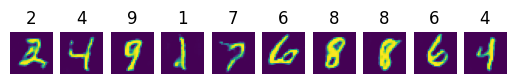

Epoch 42----Generator Loss:: 1.675869----Discriminator Loss:: 2.288814
Epoch 42----Generator Loss:: 1.442322----Discriminator Loss:: 2.333568
Epoch 42----Generator Loss:: 1.458107----Discriminator Loss:: 2.194484
Epoch 42----Generator Loss:: 1.637244----Discriminator Loss:: 2.190966
Epoch 42----Generator Loss:: 1.707976----Discriminator Loss:: 2.205589


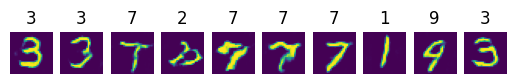

Epoch 43----Generator Loss:: 1.571312----Discriminator Loss:: 2.135962
Epoch 43----Generator Loss:: 1.431494----Discriminator Loss:: 2.315326
Epoch 43----Generator Loss:: 1.539693----Discriminator Loss:: 2.274280
Epoch 43----Generator Loss:: 1.480051----Discriminator Loss:: 2.331014
Epoch 43----Generator Loss:: 1.498333----Discriminator Loss:: 2.395723


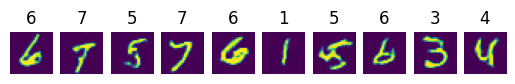

Epoch 44----Generator Loss:: 1.590834----Discriminator Loss:: 2.198558
Epoch 44----Generator Loss:: 1.665942----Discriminator Loss:: 2.160401
Epoch 44----Generator Loss:: 1.542152----Discriminator Loss:: 2.295529
Epoch 44----Generator Loss:: 1.492918----Discriminator Loss:: 2.209696
Epoch 44----Generator Loss:: 1.747881----Discriminator Loss:: 2.145682


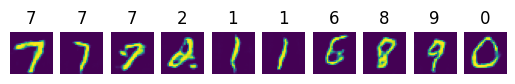

Epoch 45----Generator Loss:: 1.540029----Discriminator Loss:: 2.285220
Epoch 45----Generator Loss:: 1.439094----Discriminator Loss:: 2.297417
Epoch 45----Generator Loss:: 1.618763----Discriminator Loss:: 2.122239
Epoch 45----Generator Loss:: 1.463227----Discriminator Loss:: 2.466678
Epoch 45----Generator Loss:: 1.453942----Discriminator Loss:: 2.309720


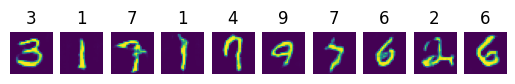

Epoch 46----Generator Loss:: 1.671670----Discriminator Loss:: 2.219593
Epoch 46----Generator Loss:: 1.628821----Discriminator Loss:: 2.264937
Epoch 46----Generator Loss:: 1.567037----Discriminator Loss:: 2.258716
Epoch 46----Generator Loss:: 1.479046----Discriminator Loss:: 2.319137
Epoch 46----Generator Loss:: 1.457313----Discriminator Loss:: 2.193887


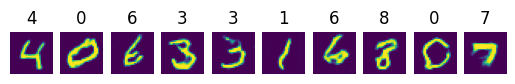

Epoch 47----Generator Loss:: 1.668007----Discriminator Loss:: 2.029294
Epoch 47----Generator Loss:: 1.556005----Discriminator Loss:: 2.145114
Epoch 47----Generator Loss:: 1.452369----Discriminator Loss:: 2.393977
Epoch 47----Generator Loss:: 1.559361----Discriminator Loss:: 2.215737
Epoch 47----Generator Loss:: 1.639742----Discriminator Loss:: 2.292755


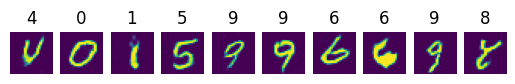

Epoch 48----Generator Loss:: 1.443016----Discriminator Loss:: 2.290795
Epoch 48----Generator Loss:: 1.500784----Discriminator Loss:: 2.264437
Epoch 48----Generator Loss:: 1.599669----Discriminator Loss:: 2.157382
Epoch 48----Generator Loss:: 1.580720----Discriminator Loss:: 2.241460
Epoch 48----Generator Loss:: 1.608051----Discriminator Loss:: 2.176327


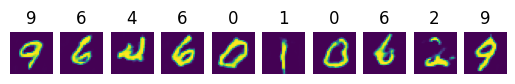

Epoch 49----Generator Loss:: 1.546532----Discriminator Loss:: 2.550962
Epoch 49----Generator Loss:: 1.554873----Discriminator Loss:: 2.212830
Epoch 49----Generator Loss:: 1.514453----Discriminator Loss:: 2.426200
Epoch 49----Generator Loss:: 1.592635----Discriminator Loss:: 2.173091
Epoch 49----Generator Loss:: 1.561185----Discriminator Loss:: 2.212234


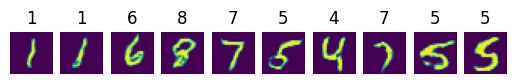

Epoch 50----Generator Loss:: 1.625683----Discriminator Loss:: 2.183315
Epoch 50----Generator Loss:: 1.677877----Discriminator Loss:: 2.190326
Epoch 50----Generator Loss:: 1.443782----Discriminator Loss:: 2.340396
Epoch 50----Generator Loss:: 1.645851----Discriminator Loss:: 2.204635
Epoch 50----Generator Loss:: 1.642927----Discriminator Loss:: 2.113919


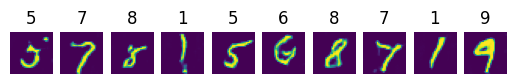

In [6]:
DModel = Discriminator()
GModel = Generator()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optG = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
optD = tf.keras.optimizers.Adam(learning_rate=1e-4)

def lossDfn(predR,predR_C,predR_L,predF,predF_C,predF_L,C,L):
    lossR = bce(tf.ones_like(predR),predR)
    lossF = bce(tf.zeros_like(predF),predF)
    lossC = cce(C,predR_C) + cce(C,predF_C)
    lossL = tf.reduce_mean(tf.square(predF_L-L) )   ## MSE
    return lossR+lossF+lossC+lossL

def lossGfn(predF,predF_C,predF_L,C,L):
    lossFR = bce(tf.ones_like(predF),predF)
    lossC = cce(C,predF_C)
    lossL = tf.reduce_mean(tf.square(predF_L-L) )
    return lossFR+lossC+lossL

@tf.function
def trainStep(Images,Labels):
    Seeds = tf.random.normal([Labels.shape[0],noise_len])
    Latents = tf.random.normal([Labels.shape[0],latent_len])
    with tf.GradientTape() as tapeG, tf.GradientTape() as tapeD:
        FakeImgs = GModel((Seeds,Labels,Latents),training=True)
        predF,predF_C,predF_L = DModel(FakeImgs,training=True)
        predR,predR_C,predR_L = DModel(Images,training=True)
        lossG = lossGfn(predF,predF_C,predF_L,Labels,Latents)
        lossD = lossDfn(predR,predR_C,predR_L,predF,predF_C,predF_L,Labels,Latents)
    gradG = tapeG.gradient(lossG,GModel.trainable_variables) 
    gradD = tapeD.gradient(lossD,DModel.trainable_variables)
    optG.apply_gradients(zip(gradG,GModel.trainable_variables))
    optD.apply_gradients(zip(gradD,DModel.trainable_variables))
    return lossG,lossD


def testStep(test_num = 10):
    testlabel = np.random.randint(10, size=test_num)
    testseed =tf.random.normal([test_num,noise_len])
    testlatent =tf.random.normal([test_num,latent_len])
    FakeImgs = GModel((testseed,tf.convert_to_tensor(testlabel),testlatent),training=False)
    showBatchImg(FakeImgs, testlabel, maxNum=test_num)


for epoch in range(50):
    counter = 0
    for _ , (Images,Labels) in enumerate(trainloader):
        lossG,lossD = trainStep(Images,Labels)
        counter += 1
        if counter%100 == 5:
            print(f'Epoch {epoch+1}----Generator Loss:: {lossG:>7f}----Discriminator Loss:: {lossD:>7f}')
        #     DModel.save_weights('tmp/D.weights.h5')
        # if counter%100 == 55:
        #     DModel.load_weights('tmp/D.weights.h5')
    testStep(test_num = 10)

## Show Latent

此例中训练了一个Latent特征，当然也可以训练多个

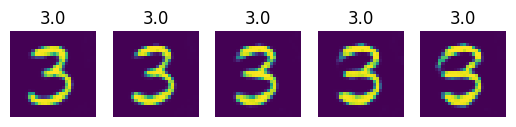

In [11]:
test_num = 10
testlabel = np.ones(test_num)*3
testseed =tf.random.normal([test_num,noise_len])
testlatent = tf.convert_to_tensor(np.linspace(0,2,test_num*latent_len).reshape(test_num,latent_len))
FakeImgs = GModel((testseed,tf.convert_to_tensor(testlabel),testlatent),training=False)
showBatchImg(FakeImgs, testlabel)